# Using YASS with GMMSort feature extraction step

The following script adapts the feature extraction step described in [1] to the Yass spike sorting algorithm [2]. 

Briefly, it replaces the PCA step by a wavelet decomposition followed by a weighted-PCA. The weigths are defined using one of the 3 separability metrics discribed in [1].

This script relates to the 'yass.pipeline.run' method. Mainly, it replaces the call for yass.detect.run to yass.detect.wpca.run. To use this pipeline see the following steps:

    Install Yass-0.9 from https://github.com/paninski-lab/yass. 

    In the 'yass/detect/' folder add the 'wpca.py' routine from the GMMSort repository: https://github.com/tortlab/GMM-spike-sorting. In the 'yass/threshold' folder add also the 'dimension_reduction_wpca.py'.
    
    Run the yass calling 'yass.detect.wpca.run' instead of 'yass.detect.run' (see example bellow)

[1] Souza, B.C., Lopes-dos-Santos, V., Bacelo, J. & Tort, A.B.L. (2018). Spike sorting with Gaussian mixture models. bioRxiv.

[2] Lee, J.H., Carlson, D.E., Razaghi, H.S., Yao, W., Goetz, G.A., Hagen, E., ... & Paninski, L. (2017). Yass: Yet another spike sorter. In Advances in Neural Information Processing Systems (pp. 4002-4012).


In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import os 
import logging
import time
import logging.config                    
import importlib

import yass
from yass import preprocess
from yass import detect
from yass import threshold
from yass import cluster
from yass import deconvolute
from yass import templates as get_templates
from yass.batch import RecordingsReader
from yass.util import load_logging_config_file


In [40]:
importlib.reload(yass.detect.wpca)
importlib.reload(yass.detect.gmm_weight)
importlib.reload(yass.detect.gmm_dwt)
importlib.reload(yass.threshold.dimensionality_reduction_wpca)
importlib.reload(yass.batch.generator)
importlib.reload(yass.batch.batch)


<module 'yass.batch.batch' from '/home/bryancsouza/bryancsouza@neuro.ufrn.br/Functions/yass-0.9/src/yass/batch/batch.py'>

In [4]:
path ="/home/bryancsouza/bryancsouza@neuro.ufrn.br/Functions/GMMSort_Py"
#path ="/path/to/data"
os.chdir(path)

In [41]:
# yass.pipeline.run inputs

config = 'config_threshold.yaml';
logger_level='INFO'
clean=False;
output_dir='tmp/';
complete = False;



# configure logging module to get useful information
#logging.basicConfig(level=logging.INFO)

# set yass configuration parameters
yass.set_config(config)

# load yass configuration parameters
CONFIG = yass.read_config()
ROOT_FOLDER = CONFIG.data.root_folder
TMP_FOLDER = os.path.join(ROOT_FOLDER, output_dir)


# remove tmp folder if needed
if os.path.exists(TMP_FOLDER) and clean:
    shutil.rmtree(TMP_FOLDER)

# create TMP_FOLDER if needed
if not os.path.exists(TMP_FOLDER):
    os.makedirs(TMP_FOLDER)


# load logging config file
logging_config = load_logging_config_file()
logging_config['handlers']['file']['filename'] = os.path.join(TMP_FOLDER,'yass.log')

logging_config['root']['level'] = 'INFO'

# configure logging
logging.config.dictConfig(logging_config)

# instantiate logger
logger = logging.getLogger(__name__)

# print yass version
logger.info('YASS version: %s', yass.__version__)

# preprocess
start = time.time()
(standarized_path,
     standarized_params,
     channel_index,
     whiten_filter) = (preprocess
                       .run(output_directory=output_dir,
                        if_file_exists=CONFIG.preprocess.if_file_exists))

time_preprocess = time.time() - start

In [ ]:
"""At this point we introduce modifications in the feature extraction step:
    gmm_params is a dictionary with the following keys (use None to default
    values):
        gmtype: str
         One of 'idist', 'iinf' or 'ipeak'. Controls which separability metric to 
         use. See [1] for further details.
        max_samples: int, optional
         Define the number of samples that will be used to compute the Gaussian
         mixture model (GMM)
        replicates: int, optional
         The number of replicates of the GMM
        max_iter: int, optional
         Define the maximum number of iterations in the GMMs
        n_components: int, optional
         Define the number of Gaussians in the model
        use_channel_features: bool, optional
         If True, computes the GMMs using only the main samples for each channel, 
         as implemented in the original PCA. If False, computes the GMMs using all
         the samples.         
"""
gmm_params = {
    'gmtype': 'idist', # chose between 
    'use_channel_features': True,
    'max_samples': 1000} # or None


In [44]:

# detect using wavelets and wPCA
start = time.time()
(score, spike_index_clear,
 spike_index_all) = detect.wpca.run(standarized_path,
                               standarized_params,
                               channel_index,
                               whiten_filter,
                               output_directory=output_dir,
                               if_file_exists=CONFIG.detect.if_file_exists,
                               save_results=CONFIG.detect.save_results,
                               gmm_params=gmm_params)
time_detect = time.time() - start

"""End of modifications"""

100%|██████████| 1/1 [00:00<00:00, 315.62it/s]


The detected spikes can be viewed bellow using the RecordingsReader from Yass

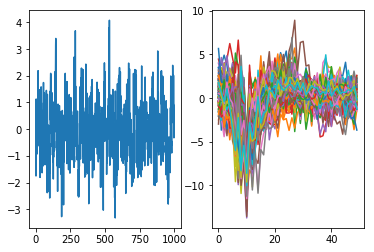

In [48]:


recordings = RecordingsReader(standarized_path)

plt.figure()

ich=2
plt.subplot(1,2,1)
plt.plot(recordings[0:1000,ich])

plt.subplot(1,2,2)
plt.hold

for (i,j) in spike_index_clear:
    plt.plot(recordings.data[i-25:i+25,j])
    
plt.show()




Below we plot the scores of the wPCA for each channel. First 3 dimensions are scores while the last 2 are features based on electrode position added by Yass. To get more or less features, change the detec.temporal_features value in the configuration file

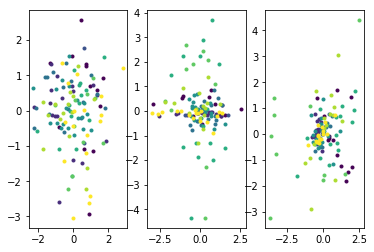

In [50]:
cmap = plt.get_cmap('viridis')
nclass = np.max(spike_index_clear[:,1])
colors = cmap(np.linspace(0, 1, nclass))

wpc1=0;
wpc2=1;

plt.figure
plt.subplot(1,3,1)
for i in range(nclass):
    idx = np.where(spike_index_clear[:,1] == i)
    plt.plot(np.squeeze(score[idx,wpc1,0]),np.squeeze(score[idx,wpc2,0]),'.',c=colors[i])


wpc1=1;
wpc2=2;

plt.subplot(1,3,2)

for i in range(nclass):
    idx = np.where(spike_index_clear[:,1] == i)
    plt.plot(np.squeeze(score[idx,wpc1,0]),np.squeeze(score[idx,wpc2,0]),'.',c=colors[i])

wpc1=3;
wpc2=4;

plt.subplot(1,3,3)

for i in range(nclass):
    idx = np.where(spike_index_clear[:,1] == i)
    plt.plot(np.squeeze(score[idx,wpc1,0]),np.squeeze(score[idx,wpc2,0]),'.',c=colors[i])

plt.show()

In [52]:

# cluster
start = time.time()
spike_train_clear, tmp_loc, vbParam = cluster.run(
    score,
    spike_index_clear,
    output_directory=output_dir,
    if_file_exists=CONFIG.cluster.if_file_exists,
    save_results=CONFIG.cluster.save_results)
time_cluster = time.time() - start

# get templates
start = time.time()
(templates,
 spike_train_clear_after_templates,
 groups,
 idx_good_templates) = get_templates.run(
    spike_train_clear, tmp_loc,
    output_directory=output_dir,
    if_file_exists=CONFIG.templates.if_file_exists,
    save_results=CONFIG.templates.save_results)
time_templates = time.time() - start

# run deconvolution
start = time.time()
spike_train = deconvolute.run(spike_index_all, templates,
                              output_directory=output_dir)
time_deconvolution = time.time() - start


yass.cluster.run@run 13/08/2018 23:04:15 INFO Randomly subsampling...
yass.cluster.run@run 13/08/2018 23:04:15 INFO Triaging...
yass.cluster.run@run 13/08/2018 23:04:15 INFO Clustering...
yass.cluster.util@run_cluster_location 13/08/2018 23:04:15 INFO Processing channel 0
yass.cluster.util@run_cluster_location 13/08/2018 23:04:15 INFO Processing channel 1
yass.cluster.util@run_cluster_location 13/08/2018 23:04:15 INFO Processing channel 2
yass.cluster.util@run_cluster_location 13/08/2018 23:04:15 INFO Processing channel 3
yass.cluster.util@run_cluster_location 13/08/2018 23:04:15 INFO Processing channel 4
yass.cluster.util@run_cluster_location 13/08/2018 23:04:15 INFO Processing channel 5
yass.cluster.util@run_cluster_location 13/08/2018 23:04:15 INFO Processing channel 6
yass.cluster.util@run_cluster_location 13/08/2018 23:04:15 INFO Processing channel 7
yass.cluster.util@run_cluster_location 13/08/2018 23:04:15 INFO Processing channel 8
yass.cluster.util@run_cluster_location 13/08/20

100%|██████████| 1/1 [00:00<00:00, 316.00it/s]

yass.templates.run@run 13/08/2018 23:04:15 INFO Templates done in 0 seconds.



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Ploting the waveforms of each cluster

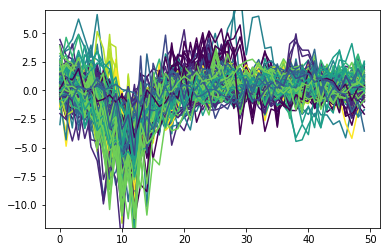

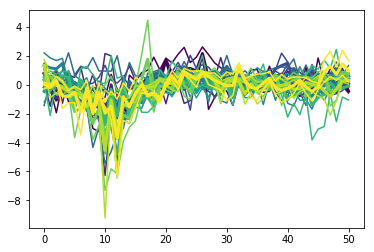

In [56]:
cmap = plt.get_cmap('viridis')
nclass = np.max(spike_train[:,1])+1
colors = cmap(np.linspace(0, 1, nclass))

plt.figure()
    
for (i,j) in spike_train:
    plt.plot(recordings[i-25:i+25,j],c=colors[j])
    plt.ylim([-12, 7])

plt.figure()
win = np.arange(-25,25+1)
for iclus in range(nclass):
    m = np.zeros(len(win))
    u = np.zeros(len(win))
    l = np.zeros(len(win))
    c=0;
    for i in win:
        idx = np.where(spike_train[:,1]==iclus)
        m[c] = np.mean(recordings.data[spike_train[idx]+i,iclus])
        u[c] = np.quantile(recordings.data[spike_train[idx]+i,iclus],0.75)
        l[c] = np.quantile(recordings.data[spike_train[idx]+i,iclus],0.25)
        c=c+1
    plt.plot(m,c=colors[iclus],linewidth=3)
    plt.hold
    plt.plot(u,c=colors[iclus])
    plt.plot(l,c=colors[iclus])
    

plt.show()

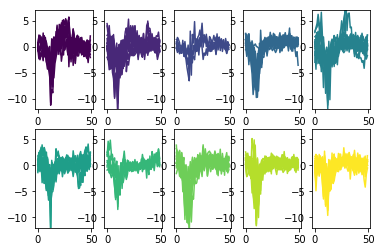

In [63]:

plt.figure
    
for j in range(nclass):
    plt.subplot(2,5,j+1)
    idx = spike_train[np.where(spike_train[:,1]==j),0]
    for i in idx[0]:
        plt.plot(recordings.data[i-25:i+25,j],c=colors[j])
        plt.ylim([-12, 7])

plt.show()

